# Facebook Graph VAE
---
Created by Lucas Hu for Teamcore AI Lab at the University of Southern California. The purpose of this notebook is to apply Graph VAE's to social network graph data (mainly, Facebook friend data) for the purposes of link prediction.

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
EDGES_DIR = 'facebook/0.edges'
FEATURES_DIR = 'facebook/0.feat'

In [3]:
# Read edge-list
f = open(EDGES_DIR)
g = nx.read_edgelist(f, nodetype=int)

In [4]:
# read features into dataframe
from pandas import read_table
df = pd.read_table(FEATURES_DIR, sep=' ', header=None, index_col=0)

In [5]:
df = df.loc[g.nodes()] # only keep connected nodes (drops unconnected nodes)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,215,216,217,218,219,220,221,222,223,224
0,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


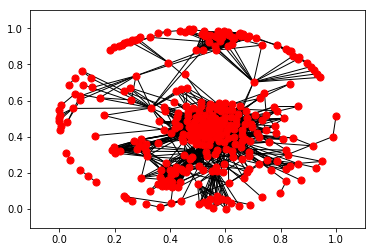

In [6]:
# draw network
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

In [7]:
adj = nx.adjacency_matrix(g) # get adjacency matrix in sparse format
features = df.values # features matrix

## 2. Data Preprocessing

In [8]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

In [9]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [10]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] # number of nodes in adjacency matrix
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] # number of non-zero entries in features matrix (or length of values list)

In [11]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)

# Add in diagonals
adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

## 3. Initialize VAE Model

In [12]:
# Define hyperparameters
LEARNING_RATE = 0.001
EPOCHS = 200
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.2

In [13]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [14]:
# How much to weigh positive examples (true edges) in cost print_function
  # Want to weigh less-frequent classes higher, so as to prevent model output bias
  # pos_weight = (num. negative samples / (num. positive samples)
pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [15]:
# Create VAE model
model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero,
                   HIDDEN1_DIM, HIDDEN2_DIM)

opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm,
                           learning_rate=LEARNING_RATE)

In [16]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [17]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(EPOCHS):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.58557 train_acc= 0.49050 val_roc= 0.76474 val_ap= 0.75713 time= 0.07867
Epoch: 0002 train_loss= 1.57590 train_acc= 0.49283 val_roc= 0.76589 val_ap= 0.75870 time= 0.02580
Epoch: 0003 train_loss= 1.55479 train_acc= 0.49064 val_roc= 0.76787 val_ap= 0.76322 time= 0.02772
Epoch: 0004 train_loss= 1.57315 train_acc= 0.49506 val_roc= 0.76877 val_ap= 0.76965 time= 0.02324
Epoch: 0005 train_loss= 1.58776 train_acc= 0.49270 val_roc= 0.77178 val_ap= 0.77639 time= 0.02358
Epoch: 0006 train_loss= 1.49686 train_acc= 0.49034 val_roc= 0.77331 val_ap= 0.78047 time= 0.02840
Epoch: 0007 train_loss= 1.47124 train_acc= 0.48770 val_roc= 0.77280 val_ap= 0.78161 time= 0.02298
Epoch: 0008 train_loss= 1.52522 train_acc= 0.48900 val_roc= 0.77261 val_ap= 0.78222 time= 0.02563
Epoch: 0009 train_loss= 1.41568 train_acc= 0.49010 val_roc= 0.77293 val_ap= 0.78403 time= 0.02128
Epoch: 0010 train_loss= 1.43225 train_acc= 0.49216 val_roc= 0.77344 val_ap= 0.78593 time= 0.02462
Epoch: 0011 train_lo

Epoch: 0091 train_loss= 0.59247 train_acc= 0.50556 val_roc= 0.83187 val_ap= 0.83706 time= 0.02120
Epoch: 0092 train_loss= 0.60310 train_acc= 0.51717 val_roc= 0.83290 val_ap= 0.83785 time= 0.02775
Epoch: 0093 train_loss= 0.59634 train_acc= 0.51252 val_roc= 0.83418 val_ap= 0.83862 time= 0.02382
Epoch: 0094 train_loss= 0.59447 train_acc= 0.52143 val_roc= 0.83642 val_ap= 0.84088 time= 0.01901
Epoch: 0095 train_loss= 0.59786 train_acc= 0.49623 val_roc= 0.83802 val_ap= 0.84237 time= 0.01917
Epoch: 0096 train_loss= 0.58649 train_acc= 0.51272 val_roc= 0.83744 val_ap= 0.84220 time= 0.01909
Epoch: 0097 train_loss= 0.59293 train_acc= 0.52291 val_roc= 0.83763 val_ap= 0.84225 time= 0.01894
Epoch: 0098 train_loss= 0.58990 train_acc= 0.52181 val_roc= 0.83795 val_ap= 0.84248 time= 0.01867
Epoch: 0099 train_loss= 0.59020 train_acc= 0.51685 val_roc= 0.83712 val_ap= 0.84150 time= 0.02171
Epoch: 0100 train_loss= 0.58467 train_acc= 0.51267 val_roc= 0.83642 val_ap= 0.84098 time= 0.02095
Epoch: 0101 train_lo

Epoch: 0183 train_loss= 0.55080 train_acc= 0.54684 val_roc= 0.88954 val_ap= 0.88691 time= 0.02461
Epoch: 0184 train_loss= 0.54736 train_acc= 0.54879 val_roc= 0.88877 val_ap= 0.88501 time= 0.03174
Epoch: 0185 train_loss= 0.55047 train_acc= 0.54502 val_roc= 0.88890 val_ap= 0.88506 time= 0.02377
Epoch: 0186 train_loss= 0.55501 train_acc= 0.54114 val_roc= 0.88896 val_ap= 0.88509 time= 0.02177
Epoch: 0187 train_loss= 0.55421 train_acc= 0.54160 val_roc= 0.88909 val_ap= 0.88529 time= 0.02202
Epoch: 0188 train_loss= 0.55054 train_acc= 0.54235 val_roc= 0.89011 val_ap= 0.88694 time= 0.02153
Epoch: 0189 train_loss= 0.54699 train_acc= 0.54270 val_roc= 0.89050 val_ap= 0.88795 time= 0.02114
Epoch: 0190 train_loss= 0.54672 train_acc= 0.54062 val_roc= 0.89146 val_ap= 0.88929 time= 0.02138
Epoch: 0191 train_loss= 0.54691 train_acc= 0.54847 val_roc= 0.89184 val_ap= 0.89068 time= 0.02105
Epoch: 0192 train_loss= 0.54952 train_acc= 0.54347 val_roc= 0.89222 val_ap= 0.89270 time= 0.02101
Epoch: 0193 train_lo